In [27]:
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import poisson
from scipy.stats import nbinom

In [28]:
from deep_uncertainty.evaluation.calibration import compute_double_poisson_nll, compute_discrete_ece
# within evaluation


# Prescription Data

In [29]:

npz = np.load('/Users/joshuaphelps/Misc/Research/deep_uncertainty/prescriptionData/prescriptions.npz')
npz.files
dataframes = {}
for key in npz.files:
    dataframes[key] = pd.DataFrame(npz[key])

X_train = dataframes['X_train']
X_val = dataframes['X_val']
X_test = dataframes['X_test']
y_train = dataframes['y_train']
y_val = dataframes['y_val']
y_test = dataframes['y_test']



__Possion__

In [30]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
y_test_pred = poisson_training_results.predict(X_test)
y_val_pred = poisson_training_results.predict(X_val)
y_train_pred = poisson_training_results.predict(X_train)

RMSE

In [31]:
print('Poisson Training RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Poisson Validation RMSE:', np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('Poisson Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

Poisson Training RMSE: 6.355172330828325
Poisson Validation RMSE: 5.582907022772484
Poisson Test RMSE: 6.703249377424615


MAE

In [32]:
print('Poisson Training MAE:', mean_absolute_error(y_train, y_train_pred))
print('Poisson Validation MAE:', mean_absolute_error(y_val, y_val_pred))
print('Poisson Test MAE:', mean_absolute_error(y_test, y_test_pred))

Poisson Training MAE: 3.1981125604293004
Poisson Validation MAE: 3.1380766247605267
Poisson Test MAE: 3.1590543721332645


NLL

In [33]:
y_true = np.array(y_test)
mu = np.array(y_test_pred)
phi = mu
nll = compute_double_poisson_nll(y_true, mu, phi)
print('Poisson Test NLL:', nll)

Poisson Test NLL: 59.726370467290316


ECE

In [35]:
# post_predictive = poisson(mu=y_test_pred)
# ece = compute_discrete_ece(y_true, post_predictive)
# print(post_predictive)

poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
lambdas = np.array(predictions_summary_frame['mean'])
from scipy.special import factorial
probs = (np.exp(-lambdas) * (lambdas ** y_test_pred)) / factorial(y_test_pred)
print(y_test_pred)
print(y_test[0])
print(probs)
ece = compute_discrete_ece(np.array(y_test[0]), np.array(y_test_pred), np.array(probs))
print(f"ECE: {ece}")

0        0.863868
1        1.999763
2        2.322356
3        0.763028
4       91.731634
          ...    
2273     0.647707
2274     1.960359
2275     1.940872
2276     3.593172
2277     2.957822
Length: 2278, dtype: float64
0        2
1        0
2        5
3        0
4       31
        ..
2273     0
2274     0
2275     1
2276     2
2277     0
Name: 0, Length: 2278, dtype: int64
0       0.391065
1       0.270685
2       0.252612
3       0.411361
4       0.041616
          ...   
2273    0.438935
2274    0.273169
2275    0.274422
2276    0.205648
2277    0.225545
Length: 2278, dtype: float64


/Users/joshuaphelps/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


ValueError: missing values must be missing in the same location both left and right sides

MP

In [ ]:
mp = 1/mu
median_mp = np.median(mp)
print('Poisson Test Median MP:', median_mp)

Poisson Test Median MP: 0.36140196304564176


__NB2__

In [ ]:
y_train = y_train.rename(columns={0: 'cnt'})
y_test = y_test.rename(columns={0: 'cnt'})
df_train = pd.concat([X_train, y_train], axis=1)
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_87125/3868232377.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()


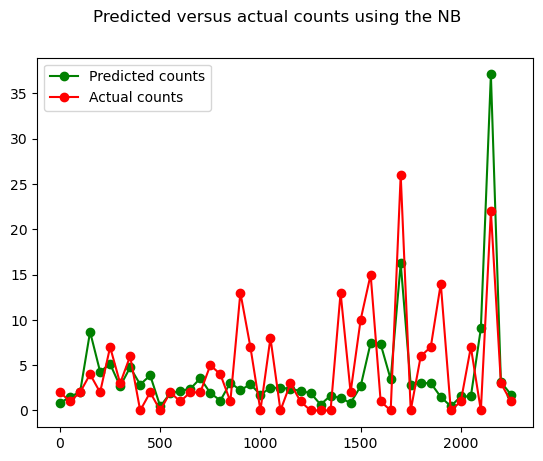

In [ ]:
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
# print(predictions_summary_frame)
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['cnt']
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the NB')
predicted_counts1 = predicted_counts[::50]
actual1 = actual_counts[::50]
predicted, = plt.plot(predicted_counts1, 'go-', label='Predicted counts')
actual,  = plt.plot(actual1, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [ ]:
y_test_pred_nb2 = nb2_training_results.predict(X_test)
y_val_pred_nb2 = nb2_training_results.predict(X_val)
y_train_pred_nb2 = nb2_training_results.predict(X_train)

RMSE

In [ ]:
print('NB Training RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred_nb2)))
print('NB Validation RMSE:', np.sqrt(mean_squared_error(y_val, y_val_pred_nb2)))
print('NB Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_nb2)))

NB Training RMSE: 37.52797989901532
NB Validation RMSE: 23.382007491854587
NB Test RMSE: 39.85040150555174


MAE

In [ ]:
print('NB Training MAE:', mean_absolute_error(y_train, y_train_pred_nb2))
print('NB Validation MAE:', mean_absolute_error(y_val, y_val_pred_nb2))
print('NB Test MAE:', mean_absolute_error(y_test, y_test_pred_nb2))

NB Training MAE: 5.127788683774355
NB Validation MAE: 4.986239866916359
NB Test MAE: 5.539398513906124


NLL

In [ ]:
y_true = np.array(y_test)
mu = np.array(y_test_pred_nb2)
variance = y_test_pred + y_test_pred**2 * aux_olsr_results.params[0]
phi = np.array(mu/variance)
nll = compute_double_poisson_nll(y_true, mu, phi)
print('Poisson Test NLL:', nll)

/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_87125/2323564253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variance = y_test_pred + y_test_pred**2 * aux_olsr_results.params[0]


Poisson Test NLL: 4.00004281922323


ECE

In [ ]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
lambdas = np.array(predictions_summary_frame['mean'])
from scipy.special import factorial
probs = (np.exp(-lambdas) * (lambdas ** y_test_pred)) / factorial(y_test_pred)

ece = compute_discrete_ece(np.array(y_test[0]), np.array(y_test_pred), np.array(probs))
print(f"ECE: {ece}")

MEDIAN MP

In [ ]:
mp = 1/variance
median_mp = np.median(mp)
print('Poisson Test Median MP:', median_mp)

Poisson Test Median MP: 0.1366997489698405
